In [1]:
# ===============================
# Core Python Libraries
# ===============================
import os
import pickle
import joblib
import numpy as np
import pandas as pd
from collections import Counter
from scipy.special import expit  # sigmoid

# ===============================
# Data Visualization
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# ===============================
# NLP: NLTK & Gensim
# ===============================
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.util import ngrams
import gensim.downloader as api

# ===============================
# Scikit-learn: Preprocessing, Models, Metrics
# ===============================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ===============================
# TensorFlow / Keras
# ===============================
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Input, Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# ===============================
# Transformers (Hugging Face)
# ===============================
from transformers import (
    AutoTokenizer, AutoModel,
    RobertaTokenizer, RobertaModel,
    BertTokenizer, BertForSequenceClassification,
    XLNetTokenizer, XLNetForSequenceClassification
)
import torch
from torch.optim import AdamW

# ===============================
# Custom Modules
# ===============================
from metrics_calculator import MetricsCalculator
from graphs import GraphPlotter
MODEL_DIR = "model"
os.makedirs(MODEL_DIR, exist_ok=True)

In [2]:
Target_labels = ["Secure", "Not Secure"]
Target_labels1 = ["Failure", "Success"]

metrics_calculator_wlb = MetricsCalculator(Target_labels)
metrics_calculator_wlb1 = MetricsCalculator(Target_labels1)

In [3]:
def upload_dataset(file_path):
    """Load the dataset from a CSV file"""
    df = pd.read_csv(file_path,)
    return df

In [4]:
path=r"Railway_Communication_Security_Dataset.csv"

In [5]:
df= upload_dataset(path)
df

,Message_ID,Original_Message,Transmitted_Message,Error_Correction_Applied,Corrected_Message,Encryption_Type,Encrypted_Message,Decrypted_Message,Authentication_Status,Transmission_Time (ms),Error_Rate (%),Throughput (Mbps),Data_Integrity (%),Target
0,1,Departing Station Train Maintenance Maintenance,Departing Station Train Maintenance Maintenance,0,Departing Station Train Maintenance Maintenance,RSA,gAAAAABnlGiKjBi1aUV5bvSnEC9D-7DH1sSTPXO_l4dKvi...,Departing Station Train Maintenance Maintenance,Failure,7.93,0.85,58.90,99.15,Not Secure
1,2,Train Departing Departing Delays Station,Train Departing Departing Delays Station,0,Train Departing Departing Delays Station,HybridRSA-Blowfish,gAAAAABnlGiLAL_RhK1CDurXQHdJ2SPvIMHjog2eYKtoDf...,Train Departing Departing Delays Station,Failure,14.13,1.34,52.79,98.66,Not Secure
2,3,Arriving On-Time Station Train Station Train D...,AUriving On-Time Station Train Station Train D...,1,Arriving On-Time Station Train Station Train D...,Blowfish,gAAAAABnlGiLy8Zh8HZsKKPToe1xXY0mHIIzfJq503W_ha...,Arriving On-Time Station Train Station Train D...,Success,12.45,0.85,51.08,99.15,Secure
3,4,Departing Train On-Time On-Time Maintenance De...,Departing Train On-Time On-Time Maintenance De...,0,Departing Train On-Time On-Time Maintenance De...,HybridRSA-Blowfish,gAAAAABnlGiLD_F5Np_jfUYVsqMORt4meHDgKFl6z-gP6A...,Departing Train On-Time On-Time Maintenance De...,Failure,5.37,1.45,50.52,98.55,Not Secure
4,5,Arriving Delays Station Arriving Delays Arrivi...,Arriving Delays Station Arriving Delays Arrivi...,0,Arriving Delays Station Arriving Delays Arrivi...,Blowfish,gAAAAABnlGiLFtVSKqNHji1q8dDd4nwTntySk1HUk58KSY...,Arriving Delays Station Arriving Delays Arrivi...,Failure,7.93,0.72,50.08,99.28,Not Secure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,On-Time Maintenance On-Time Delays,On-Time Maintenance On-Time Delays,0,On-Time Maintenance On-Time Delays,RSA,gAAAAABnlGiM9C_Vv2NYjymIN1jGawEdQPvSS-itla3Ov8...,On-Time Maintenance On-Time Delays,Failure,12.80,1.56,54.29,98.44,Not Secure
4996,4997,Delays Delays Station On-Time Departing Station,Delays Delays Station On-Time DepartingnStation,1,Delays Delays Station On-Time Departing Station,Blowfish,gAAAAABnlGiMOagxEI3alX_sFyqkBmvU1go0dxjgBHHjNy...,Delays Delays Station On-Time Departing Station,Success,9.08,0.31,57.75,99.69,Secure
4997,4998,Train Arriving Maintenance Train Departing Tra...,Train Arriving Maintenance Train Departing Tra...,0,Train Arriving Maintenance Train Departing Tra...,HybridRSA-Blowfish,gAAAAABnlGiMaSbxhTLnWuZnc_nVZCkLzQFSL9urB7VAL-...,Train Arriving Maintenance Train Departing Tra...,Failure,10.40,0.99,58.71,99.01,Not Secure
4998,4999,Station Station On-Time Departing Station Station,Station Station On-Time Departing Station Station,0,Station Station On-Time Departing Station Station,Blowfish,gAAAAABnlGiM7rUpFKxp1e-wqUjMS4HKkD8qkKwHCyQegU...,Station Station On-Time Departing Station Station,Failure,11.63,1.33,50.89,98.67,Not Secure


In [6]:
def preprocess_data(df, save_path=None, target_cols=None):

    global label_encoders
    label_encoders = {}  # dictionary to hold encoders for each target column

    if save_path and os.path.exists(save_path):
        print(f"Loading existing preprocessed file: {save_path}")
        df = pd.read_csv(save_path)
    else:
        print("Preprocessing data" + (f" and saving to: {save_path}" if save_path else " (no saving)"))
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))

        def clean_text(text):
            text = str(text).lower()
            tokens = word_tokenize(text)
            tokens = [lemmatizer.lemmatize(t) for t in tokens if t.isalnum() and t not in stop_words]
            return ' '.join(tokens)

        # Separate target columns
        target_df = None
        if target_cols:
            existing_targets = [col for col in target_cols if col in df.columns]
            target_df = df[existing_targets].copy()
            df = df.drop(columns=existing_targets)

        # Process text columns
        text_columns = df.select_dtypes(include='object').columns
        for col in text_columns:
            df[f'processed_{col}'] = df[col].apply(clean_text)

        # Drop original text columns
        df.drop(columns=text_columns, inplace=True)

        # Reattach target columns
        if target_df is not None:
            for col in target_df.columns:
                df[col] = target_df[col]

        # Save only if path is specified
        if save_path:
            df.to_csv(save_path, index=False)

    # Select processed and numerical columns
    processed_text_cols = [col for col in df.columns if col.startswith('processed_')]
    non_text_cols = [col for col in df.columns if col not in processed_text_cols + (target_cols if target_cols else [])]

    # Join processed text columns into one string
    X_text = df[processed_text_cols].astype(str).agg(' '.join, axis=1)

    # Combine with numerical columns if any
    X_numeric = df[non_text_cols].values if non_text_cols else None
    if X_numeric is not None and len(X_numeric) > 0:
        X = [f"{text} {' '.join(map(str, numeric))}" for text, numeric in zip(X_text, X_numeric)]
    else:
        X = X_text.tolist()

    # Encode multiple target columns
    Y_dict = {}
    if target_cols:
        for col in target_cols:
            if col in df.columns:
                le = LabelEncoder()
                Y_dict[col] = le.fit_transform(df[col])
                label_encoders[col] = le

    return X, Y_dict

In [7]:
X, Y_dict = preprocess_data(df, save_path="model/cleaned_data2.csv", target_cols=["Target"])

Preprocessing data and saving to: model/cleaned_data2.csv


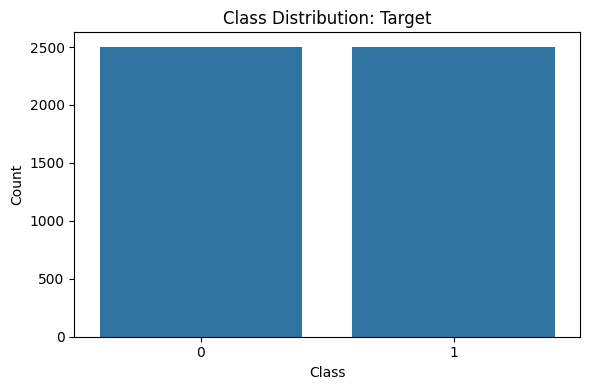

In [8]:
def plot_target_distributions(Y_dict):
    # Convert to DataFrame for easy plotting
    y_df = pd.DataFrame(Y_dict)

    # Plot each column
    for col in y_df.columns:
        plt.figure(figsize=(6, 4))
        sns.countplot(x=y_df[col])
        plt.title(f'Class Distribution: {col}')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
plot_target_distributions(Y_dict)

In [9]:
from tqdm import tqdm
def sbert_feature_extraction(texts, model_name='sentence-transformers/all-MiniLM-L6-v2', batch_size=32):
    """Extract SBERT features from texts with tqdm progress bar."""
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()

    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting SBERT embeddings"):
        batch_texts = texts[i:i+batch_size]
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')

        with torch.no_grad():
            model_output = model(**encoded_input)

        token_embeddings = model_output.last_hidden_state
        attention_mask = encoded_input['attention_mask']
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
        sum_mask = input_mask_expanded.sum(dim=1)
        embeddings = sum_embeddings / sum_mask

        all_embeddings.append(embeddings.cpu().numpy())

    X = np.vstack(all_embeddings)
    return X, model


In [10]:
def feature_extraction(X_text, method='SBERT_paraphrase', model_dir='model', is_train=True):

    x_file = os.path.join(model_dir, f'X_{method}.pkl')

    print(f"[INFO] Feature extraction method: {method}, Train mode: {is_train}")
    model_name = 'sentence-transformers/paraphrase-mpnet-base-v2'

    if is_train:
        if os.path.exists(x_file):
            print(f"[INFO] Loading cached Lightweight RoBERTa features from {x_file}")
            X = joblib.load(x_file)
        else:
            print("[INFO] Computing SBERT_semantic_similarity features...")
            X, model = sbert_feature_extraction(X_text, model_name=model_name)
            joblib.dump(X, x_file)
    else:
        print("[INFO] Performing SBERT_semantic_similarity feature extraction for testing...")
        X, model = sbert_feature_extraction(X_text, model_name=model_name)

    return X

In [11]:
features = feature_extraction(X, method='SBERT_paraphrase',is_train=True)

[INFO] Feature extraction method: SBERT_paraphrase, Train mode: True
[INFO] Computing SBERT_semantic_similarity features...


Extracting SBERT embeddings: 100%|███████████████████████████████████████████████████| 157/157 [04:50<00:00,  1.85s/it]


In [12]:
from imodels import TaoTreeClassifier

def train_dndt_classifier(features, Y_dict, Algorithm_prefix="MyAlgo"):
    dndt_models = {}

    for target_name, y_encoded in Y_dict.items():

        model_path = f"model/{Algorithm_prefix}_{target_name}_dndt_model.pkl"
        algo_name = f"{Algorithm_prefix} DNDT [{target_name}]"

        X_train, X_test, y_train, y_test = train_test_split(
            features, y_encoded, test_size=0.2, random_state=42
        )

        print(f"🔧 Training DNDT Classifier for: {target_name}")

        if os.path.exists(model_path):
            model = joblib.load(model_path)
            print(f"🔁 Loaded existing model for classification: {target_name}")
        else:
            model = TaoTreeClassifier()
            model.fit(X_train, y_train)
            joblib.dump(model, model_path)

        y_pred = model.predict(X_test)

        try:
            y_score = model.predict_proba(X_test)
        except:
            y_score = None

        if target_name == "Target":
            metrics_calculator_wlb.calculate_metrics(algo_name, y_pred, y_test, y_score)
        else:
            print(f"No metrics_calculator defined for: {target_name}")

        dndt_models[target_name] = model

    return dndt_models

🔧 Training DNDT Classifier for: Target
classes_ [0 1] preds [1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1.
 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0.
 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.
 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 

F:\sak informatics\28. Cyber Security\28. Cyber Security\metrics_calculator.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.metrics_df = pd.concat([self.metrics_df, metrics_entry], ignore_index=True)
F:\sak informatics\28. Cyber Security\28. Cyber Security\metrics_calculator.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.class_performance_dfs[str(category)] = pd.concat([self.class_performance_dfs[str(category)], class_entry], ignore_index=True)
F:\sak informatics\28. Cyber S

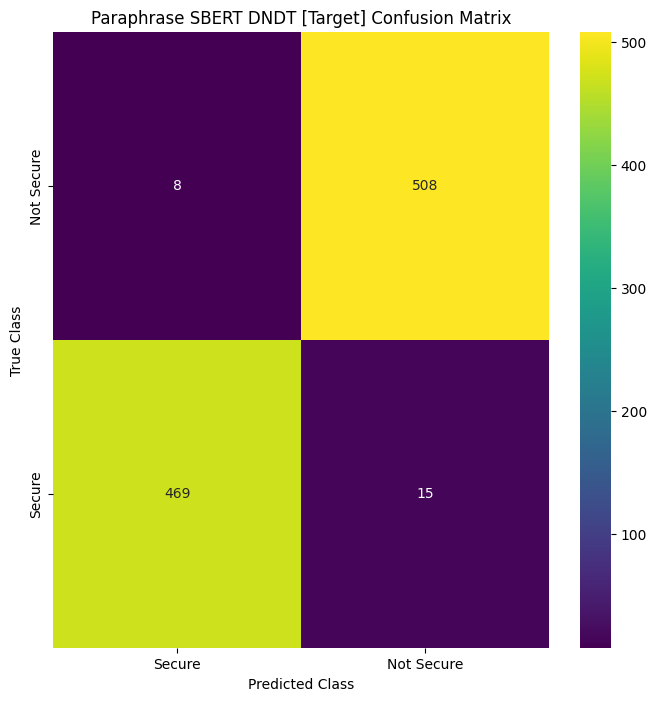

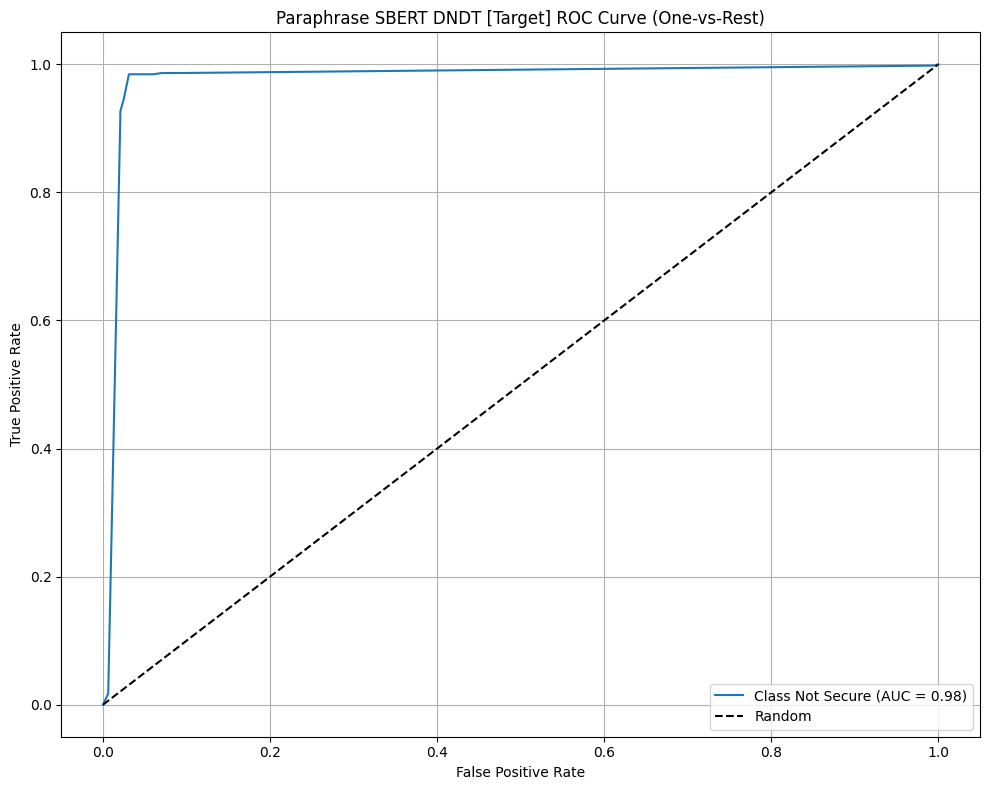

{'Target': TaoTreeClassifier()}

In [13]:
features_pos = np.abs(features)
train_dndt_classifier(features_pos, Y_dict,"Paraphrase SBERT")

In [14]:
from imodels import DecisionTreeCCPClassifier
from sklearn.tree import DecisionTreeClassifier

def train_decisiontreeccp_classifier(features, Y_dict, Algorithm_prefix="MyAlgo"):
    dtccp_models = {}

    for target_name, y_encoded in Y_dict.items():

        model_path = f"model/{Algorithm_prefix}_{target_name}_dtccp_model.pkl"
        algo_name = f"{Algorithm_prefix} DecisionTreeCCP [{target_name}]"

        X_train, X_test, y_train, y_test = train_test_split(
            features, y_encoded, test_size=0.2, random_state=42
        )

        print(f"🌲 Training DecisionTreeCCP Classifier for: {target_name}")

        if os.path.exists(model_path):
            model = joblib.load(model_path)
            print(f"🔁 Loaded existing model for classification: {target_name}")
        else:
            base_tree = DecisionTreeClassifier(random_state=42)
            model = DecisionTreeCCPClassifier(estimator_=base_tree)
            model.fit(X_train, y_train)
            joblib.dump(model, model_path)

        y_pred = model.predict(X_test)

        try:
            y_score = model.predict_proba(X_test)
        except:
            y_score = None

        if target_name == "Target":
            metrics_calculator_wlb.calculate_metrics(algo_name, y_pred, y_test, y_score)
        else:
            print(f"No metrics_calculator defined for: {target_name}")

        dtccp_models[target_name] = model

    return 


🌲 Training DecisionTreeCCP Classifier for: Target


F:\anaconda\envs\py312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
F:\anaconda\envs\py312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
F:\anaconda\envs\py312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
F:\anaconda\envs\py312\Lib\site-pa

Paraphrase SBERT DecisionTreeCCP [Target] Accuracy  : 48.40
Paraphrase SBERT DecisionTreeCCP [Target] Precision : 24.20
Paraphrase SBERT DecisionTreeCCP [Target] Recall    : 50.00
Paraphrase SBERT DecisionTreeCCP [Target] FScore    : 32.61
Paraphrase SBERT DecisionTreeCCP [Target] Classification Report
Paraphrase SBERT DecisionTreeCCP [Target]
              precision    recall  f1-score   support

      Secure       0.48      1.00      0.65       484
  Not Secure       0.00      0.00      0.00       516

    accuracy                           0.48      1000
   macro avg       0.24      0.50      0.33      1000
weighted avg       0.23      0.48      0.32      1000




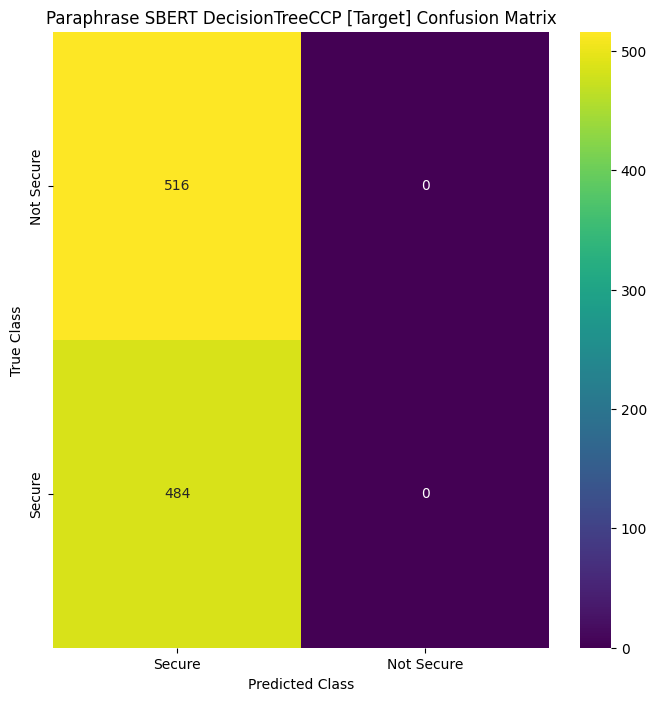

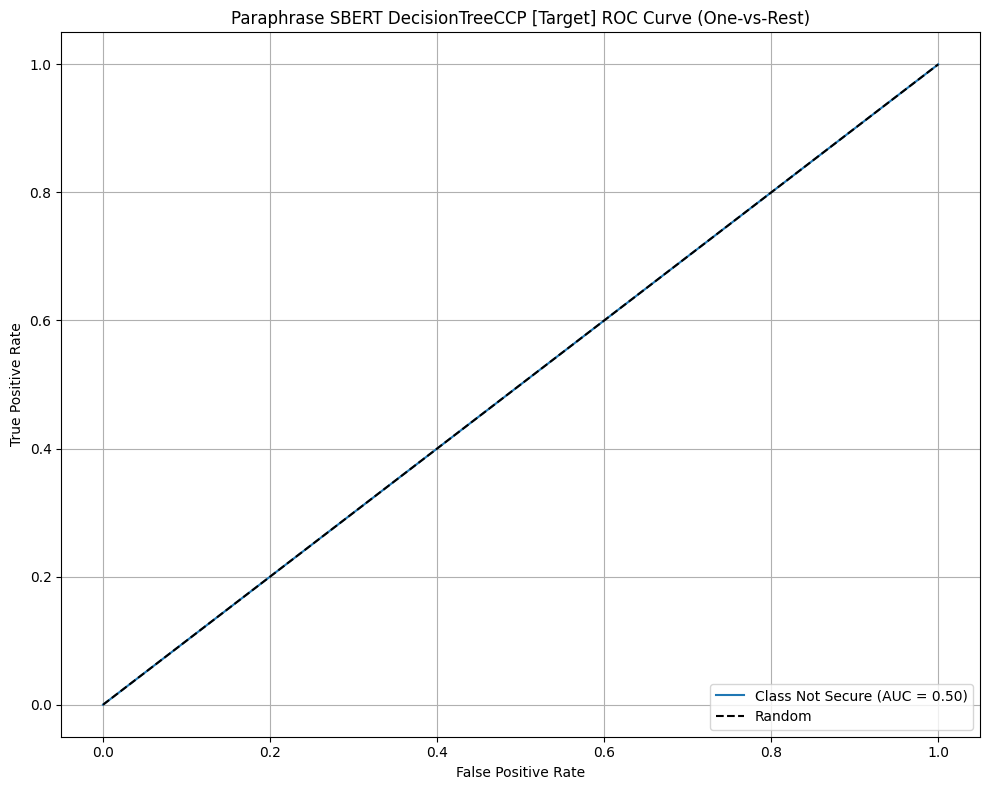

In [15]:
features_pos = np.abs(features)
train_decisiontreeccp_classifier(features_pos, Y_dict,"Paraphrase SBERT")

In [16]:
from imodels import RuleFitClassifier

def train_rulefit_classifier(features, Y_dict, Algorithm_prefix="MyAlgo"):
    rulefit_models = {}

    for target_name, y_encoded in Y_dict.items():

        model_path = f"model/{Algorithm_prefix}_{target_name}_rulefit_model.pkl"
        algo_name = f"{Algorithm_prefix} RuleFit [{target_name}]"

        X_train, X_test, y_train, y_test = train_test_split(
            features, y_encoded, test_size=0.2, random_state=42
        )

        print(f"🔧 Training RuleFit Classifier for: {target_name}")

        if os.path.exists(model_path):
            model = joblib.load(model_path)
            print(f"🔁 Loaded existing model for classification: {target_name}")
        else:
            model = RuleFitClassifier(random_state=42)
            model.fit(X_train, y_train)
            joblib.dump(model, model_path)

        y_pred = model.predict(X_test)

        try:
            y_score = model.predict_proba(X_test)
        except:
            y_score = None

        if target_name == "Target":
            metrics_calculator_wlb.calculate_metrics(algo_name, y_pred, y_test, y_score)
        else:
            print(f"No metrics_calculator defined for: {target_name}")

        rulefit_models[target_name] = model

    return rulefit_models


🔧 Training RuleFit Classifier for: Target
Paraphrase SBERT RuleFit [Target] Accuracy  : 99.40
Paraphrase SBERT RuleFit [Target] Precision : 99.39
Paraphrase SBERT RuleFit [Target] Recall    : 99.41
Paraphrase SBERT RuleFit [Target] FScore    : 99.40
Paraphrase SBERT RuleFit [Target] Classification Report
Paraphrase SBERT RuleFit [Target]
              precision    recall  f1-score   support

      Secure       0.99      1.00      0.99       484
  Not Secure       1.00      0.99      0.99       516

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000




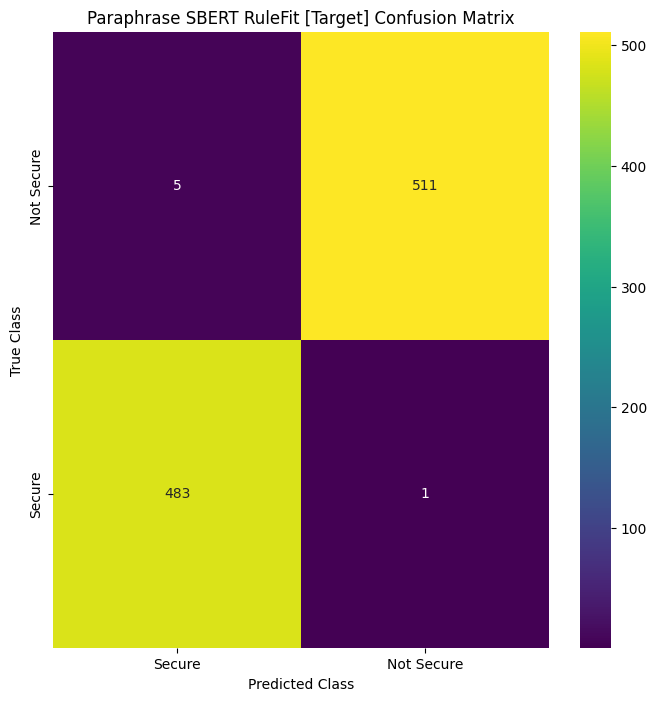

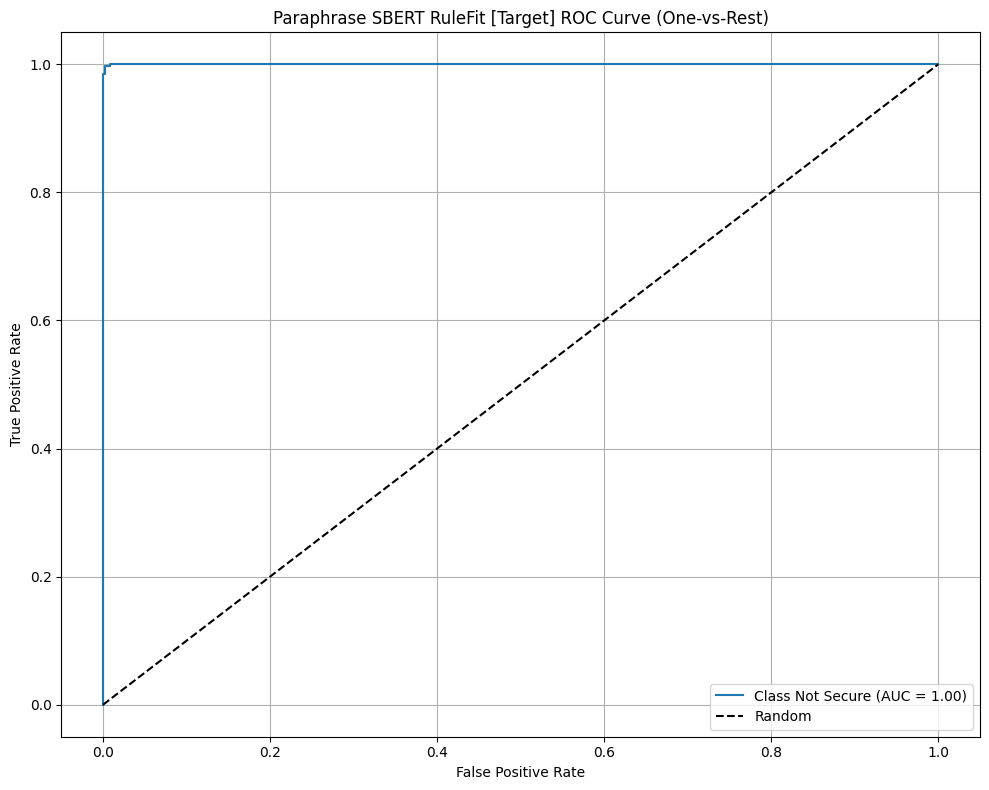

In [17]:
Rulefit_models = train_rulefit_classifier(features, Y_dict,"Paraphrase SBERT")

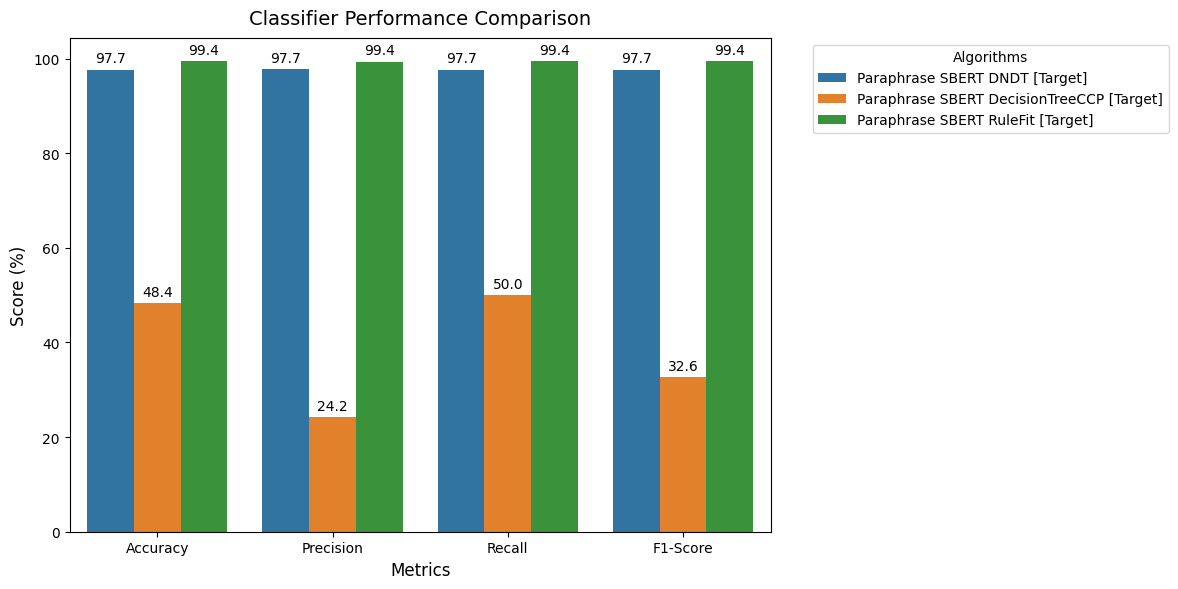

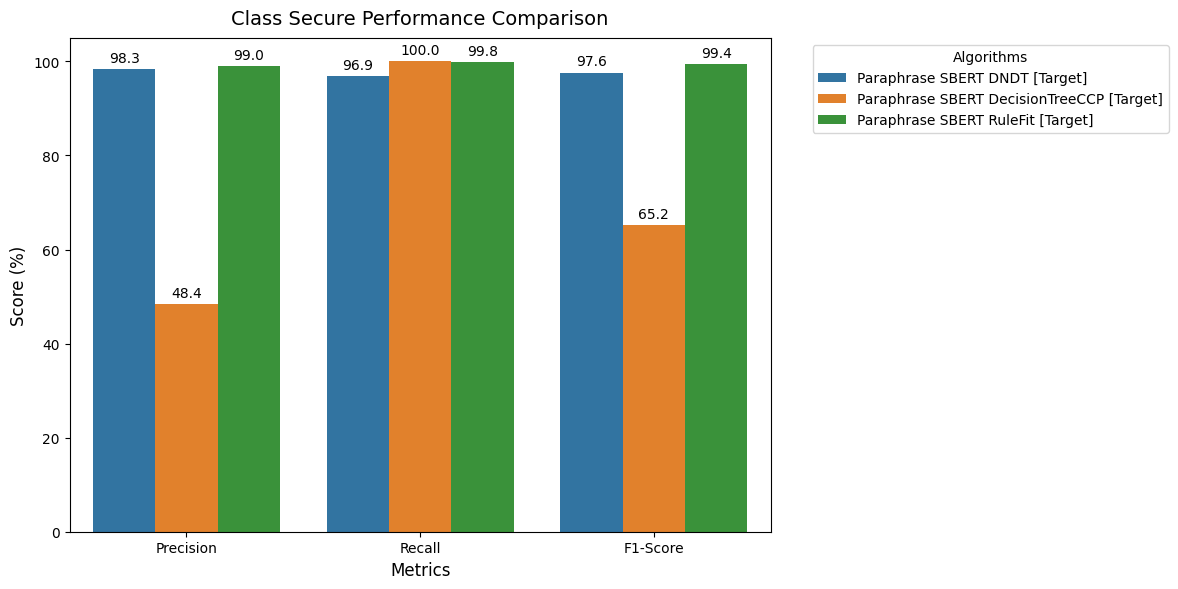

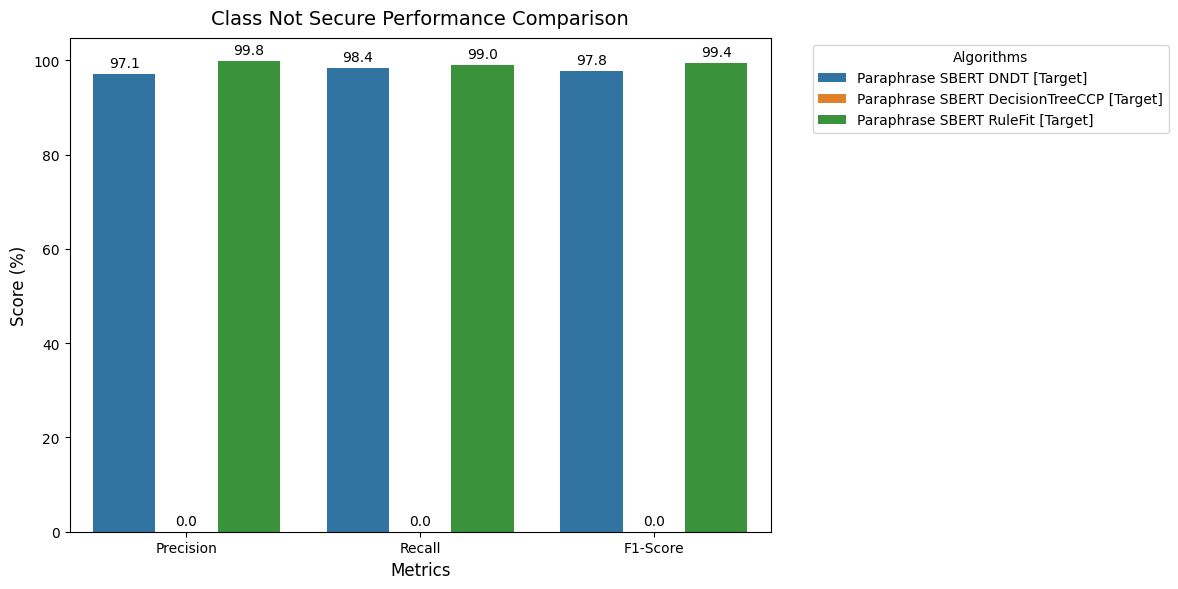

In [18]:
# Plot for Work-Life Balance
graph_plotter_wlb = GraphPlotter(metrics_calculator_wlb.metrics_df, metrics_calculator_wlb.class_performance_dfs)
graph_plotter_wlb.plot_all()

In [19]:
# Work-Life Balance
melted_df_wlb = metrics_calculator_wlb.metrics_df[['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1-Score']].copy()
melted_df_wlb = melted_df_wlb.round(3)
melted_df_wlb

,Algorithm,Accuracy,Precision,Recall,F1-Score
0,Paraphrase SBERT DNDT [Target],97.7,97.727,97.675,97.696
1,Paraphrase SBERT DecisionTreeCCP [Target],48.4,24.200,50.000,32.615
2,Paraphrase SBERT RuleFit [Target],99.4,99.390,99.412,99.400


In [20]:
test_path=r"Test_data.csv"

In [21]:
df_test1= upload_dataset(test_path)
df_test1
# Initialize result DataFrame
df_result = df_test1.copy()


In [22]:
df_test,_ = preprocess_data(df_test1)

Preprocessing data (no saving)


In [23]:
features_test = feature_extraction(df_test,method='SBERT_paraphrase',is_train=None)

[INFO] Feature extraction method: SBERT_paraphrase, Train mode: None
[INFO] Performing SBERT_semantic_similarity feature extraction for testing...


Extracting SBERT embeddings: 100%|███████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]


In [24]:
custom_label_map = { 'Target': ["Not Secure", "Secure"]}

# Loop over each target
for target in ['Target']:
    # Predict
    y_pred = Rulefit_models[target].predict(features_test)
    original_labels = y_pred
    
    # Map to custom descriptive labels
    mapped_labels = [custom_label_map[target][label] for label in original_labels]
    
    # Add as new column
    df_result[f'Predicted_{target}'] = mapped_labels

# Final output
df_result


,Message_ID,Original_Message,Transmitted_Message,Error_Correction_Applied,Corrected_Message,Encryption_Type,Encrypted_Message,Decrypted_Message,Authentication_Status,Transmission_Time (ms),Error_Rate (%),Throughput (Mbps),Data_Integrity (%),Predicted_Target
0,4592,Arriving Station On-Time Train Delays,Arriving Station On-Time Train Delays,0,Arriving Station On-Time Train Delays,HybridRSA-Blowfish,gAAAAABnlGiMlPTFzEF5kRiBWErTPKxGzvYD9OJ3ljW0oF...,Arriving Station On-Time Train Delays,Failure,10.50,0.50,58.40,99.50,Not Secure
1,3750,Maintenance Arriving Train Arriving On-Time,Maintenance Arriving Train Arriving On-Time,0,Maintenance Arriving Train Arriving On-Time,Blowfish,gAAAAABnlGiMUaIdhUy4JznymxjIAw6sy-3xINeTe6u3vA...,Maintenance Arriving Train Arriving On-Time,Failure,12.59,0.23,50.63,99.77,Not Secure
2,1817,Train On-Time Maintenance On-Time Departing Ar...,Train On-Time Maintenance On-Time Departing Ar...,0,Train On-Time Maintenance On-Time Departing Ar...,Blowfish,gAAAAABnlGiL0imoEHZIa6iNrtrUu411KsYLA8g3jLZFsN...,Train On-Time Maintenance On-Time Departing Ar...,Failure,14.86,0.04,58.65,99.96,Not Secure
3,4489,Station Delays Train On-Time Maintenance,Station Delays Train On-Time Maintenance,0,Station Delays Train On-Time Maintenance,HybridRSA-Blowfish,gAAAAABnlGiMnTJzYyFA_m0S3A_xqI0nVrkRzCiN4TpjeP...,Station Delays Train On-Time Maintenance,Failure,5.19,0.26,55.80,99.74,Not Secure
4,2577,Train Departing Arriving On-Time,Train Departing Arriving On-Time,0,Train Departing Arriving On-Time,RSA,gAAAAABnlGiMgGhEDcdzAuv3wBcNLsd3W0Aj9Cyufv_5UF...,Train Departing Arriving On-Time,Failure,8.81,1.80,59.74,98.20,Not Secure
5,113,Station Station Train Maintenance Maintenance,Station Station Train Maintenance Maintenance,0,Station Station Train Maintenance Maintenance,Blowfish,gAAAAABnlGiL4E2_fWwvdipsiLPFei_x8Uzi97FIFZiyrf...,Station Station Train Maintenance Maintenance,Failure,7.18,0.50,52.81,99.50,Not Secure
6,4029,On-Time Maintenance Maintenance Station,On-Time Maintenance Maintenance Station,0,On-Time Maintenance Maintenance Station,HybridRSA-Blowfish,gAAAAABnlGiM_NoO8Rhq3eIAzQsJXHqIzZOZU34C04u6Up...,On-Time Maintenance Maintenance Station,Failure,8.37,0.00,56.39,100.00,Not Secure
7,1613,On-Time Train Delays Station Train Arriving,On-Time Train Delays StatiJn Train Arriving,1,On-Time Train Delays Station Train Arriving,HybridRSA-Blowfish,gAAAAABnlGiLlxPpMzK7Fjk-PJT5pzF9llyhBkhdKTsVHs...,On-Time Train Delays Station Train Arriving,Failure,6.14,1.19,54.53,98.81,Not Secure
8,1630,Delays Arriving On-Time On-Time Departing Station,Delays Arriving On-Time On-Time Departing Station,0,Delays Arriving On-Time On-Time Departing Station,Blowfish,gAAAAABnlGiLFjvzhcnJos-avgAGhaSjCEM_DCwXwHyc_E...,Delays Arriving On-Time On-Time Departing Station,Failure,7.77,1.93,51.56,98.07,Not Secure
9,1819,Maintenance Maintenance Station Delays Train D...,Maintenance Maintenance Station Delays Train D...,0,Maintenance Maintenance Station Delays Train D...,HybridRSA-Blowfish,gAAAAABnlGiLZe85fTHcmOEHgZPNr1FNdPgUxK3KYsoOlA...,Maintenance Maintenance Station Delays Train D...,Failure,7.79,1.77,50.02,98.23,Not Secure
